In [75]:
library(tidyverse)
library(GGally)
library(caret)

# Describe the data


* The following data obtained from Kaggle. 
* The data contains individual medical costs billed by health insurance based various features, like age, sex, bmi, number of children, smoke status, and regions. 
* The data was collected in 2015
* The purpose of our dataset is for learning.
* It looks like historical records digitized.

# Load the data

In [76]:
df <- read.csv("Medical_Cost.csv")
head(df)

,age,sex,bmi,children,smoker,region,charges
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622


# Explore your dataset

In [77]:
str(df)

'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : chr  "female" "male" "male" "male" ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : chr  "yes" "no" "no" "no" ...
 $ region  : chr  "southwest" "southeast" "southeast" "northwest" ...
 $ charges : num  16885 1726 4449 21984 3867 ...


In [78]:
# summary of the dataset
summary(df)

      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

In [79]:
table(df$sex)


female   male 
   662    676 

In [80]:
table(df$region)


northeast northwest southeast southwest 
      324       325       364       325 

In [81]:
table(df$smoker)


  no  yes 
1064  274 

In [82]:
# check missing values
sum(is.na(df))

[1] 0

# Initial thoughts

* In this dataset, there's no missing values
* There seems to be some outliers in the column, charges.
* unbalanced smokers and non-smokers

# Wrangling
As the dataset is clean, we cannot do much about data pre-processing. However, we divided the age and bmi variables into 4 categories for analysis. If we are going to make prediction in the future, we can do one-hot encoding on categorical variables (such as sex, region, and smoker) and removing missing values.

In [83]:
df = df %>% 
  mutate(
    # Create categories
    age_group = dplyr::case_when(
      age > 15 & age <= 24 ~ "youth",
      age > 24 & age <= 44 ~ "adult",
      age > 44 & age <= 64 ~ "middle age",
      age > 64             ~ "senior"
    ),
    # Convert to factor
    age_group = factor(
      age_group,
      level = c("youth", "adult","middle age", "senior")
    )
  )

df = df %>% 
  mutate(
    # Create categories
    BMI_group = dplyr::case_when(
      bmi <= 18.5 ~ "underweight",
      bmi > 18.5 & bmi <= 25 ~ "healthy weight",
      bmi > 25 & bmi <= 30 ~ "Overweight",
      bmi > 30             ~ "Obesity"
    ),
    # Convert to factor
    BMI_group = factor(
      BMI_group,
      level = c("underweight", "healthy weight","Overweight","Obesity")
    )
  )

# Research Questions
1. How would significant number of population who are involved in the smoking activities will be correlated with the medical costs, currently this research question is not answerable as we don't have much data for those who smoke as compared to non smoking data (as that is the unbalanced dataset).

2. Does medical costs correlated with senior people (age>64) from several BMI groups? We believe aging seniors is a significant factor that could lead to an increase in the medical costs. However, this research question is not answerable as this dataset has no data about the senior people.




# Data analysis & visualizations
Let’s look at the relationships between the charges and other numerical columns.

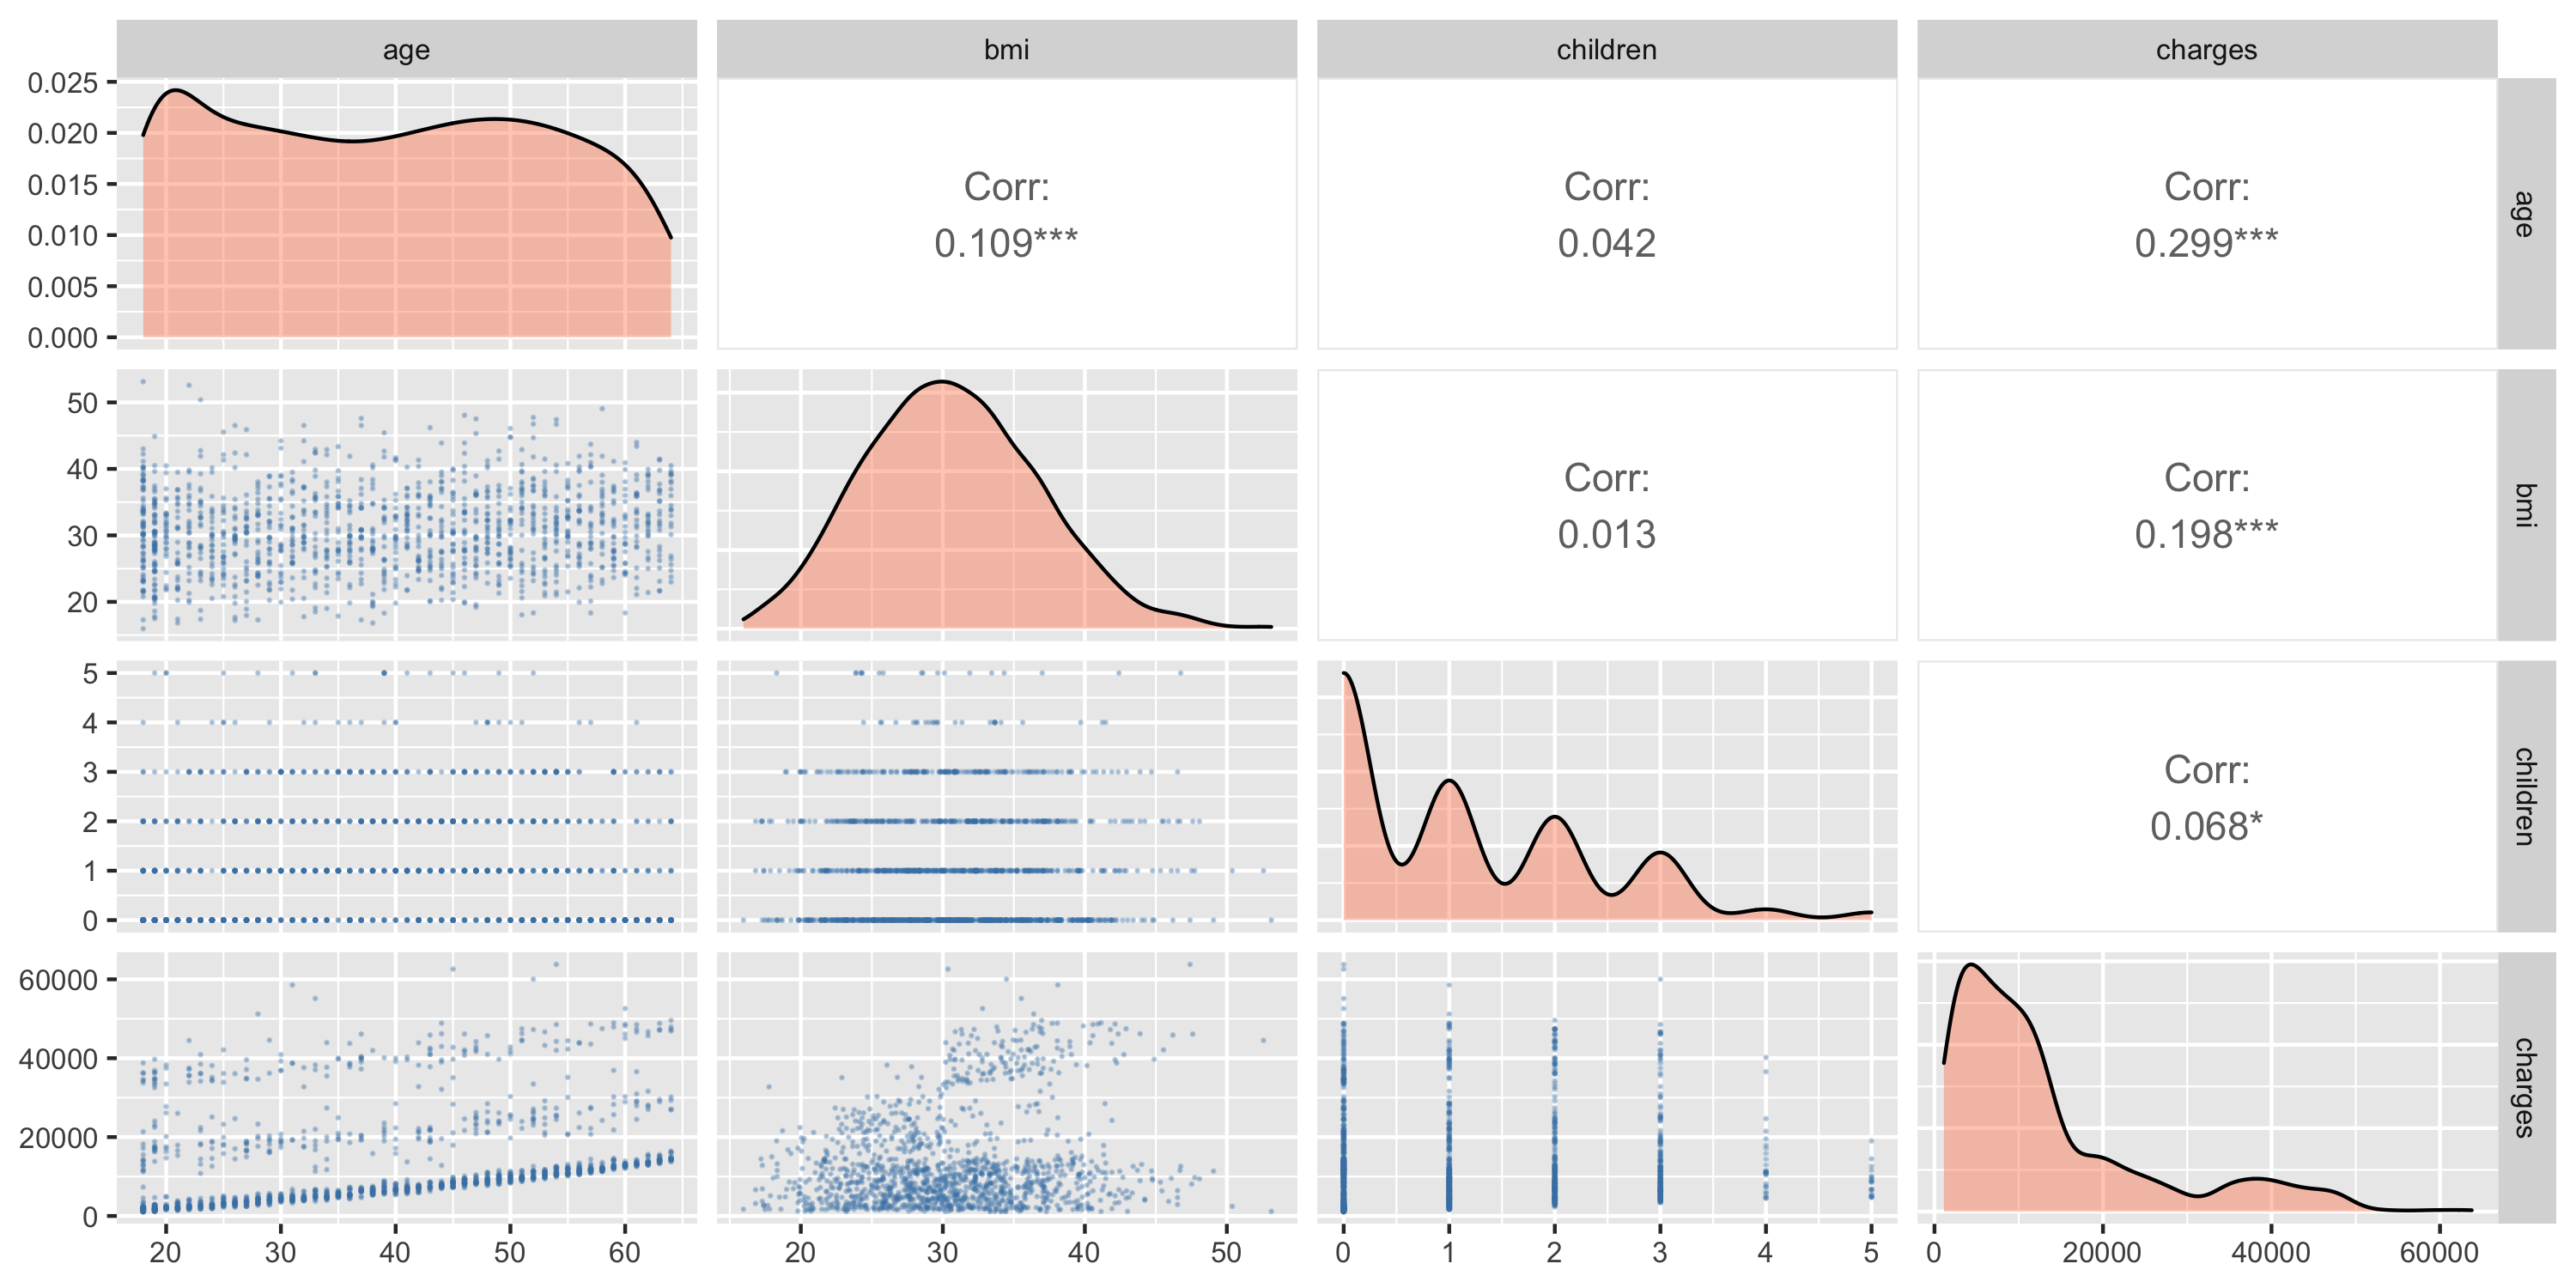

In [84]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 300)
GGally::ggpairs(df %>% select_if(is.numeric),
                progress = FALSE,
                lower = list(continuous = GGally::wrap('points', alpha = 0.3, size=0.1, color = 'steelblue')),
                diag = list(continuous = GGally::wrap('densityDiag', fill = 'coral', alpha = 0.4))) +
            theme(text = element_text(size = 10))

From the pair plot, we can see that charges is weakly correlated to BMI and age

In [93]:
temp = df %>% count(region, smoker)
holder = temp %>% 
  group_by(region) %>%
  summarise(smoker_nonsmoker_ratio=n[smoker == "yes"] / n[smoker == "no"])
temp2 = df%>%group_by(region)%>%summarise(median=median(charges))


In [94]:
holder$median_charges = temp2$median
holder

region,smoker_nonsmoker_ratio,median_charges
<chr>,<dbl>,<dbl>
northeast,0.2607004,10057.652
northwest,0.2172285,8965.796
southeast,0.3333333,9294.132
southwest,0.2172285,8798.593


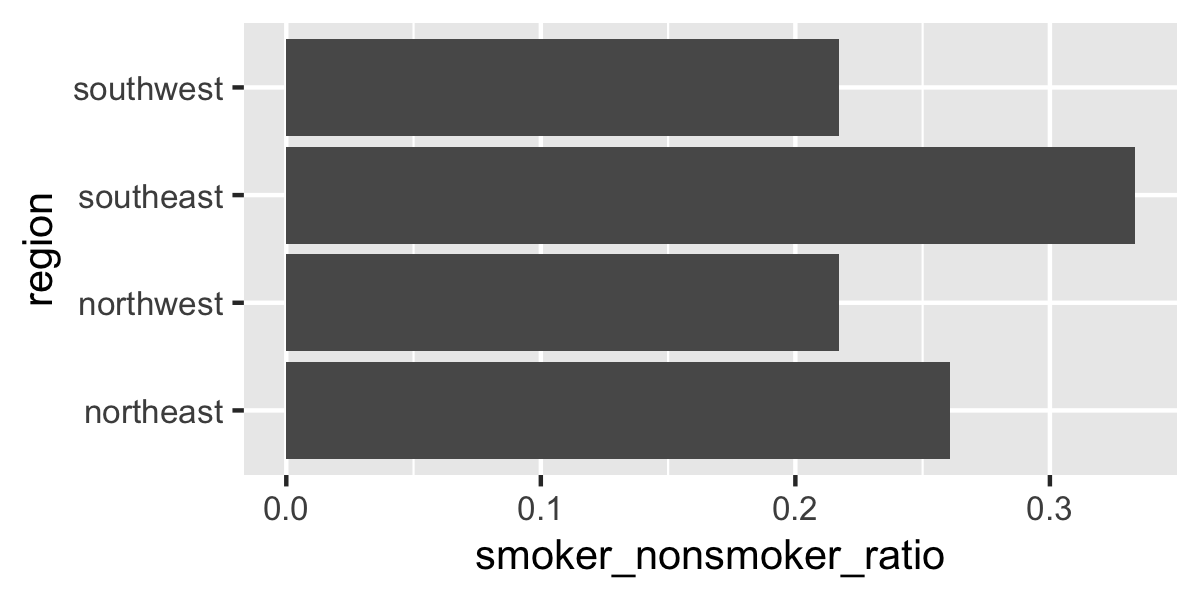

In [88]:
options(repr.plot.width=4, repr.plot.height=2, repr.plot.res = 300)
ggplot(holder, aes(x=smoker_nonsmoker_ratio,y=region)) + 
    geom_bar(position="dodge", stat="identity")+geom_col()+
            theme(text = element_text(size = 10))

We performed the above visualization to check which region wise analysis for smoker to non smoker ratio. By plotting the visualization we found that southeast region has highest smoker to non smoker ratio

In [95]:
charges_bygroups <- df%>%group_by(age_group, smoker,BMI_group) %>% summarise(Median_charges=median(charges))

`summarise()` has grouped output by 'age_group', 'smoker'. You can override using the `.groups` argument.



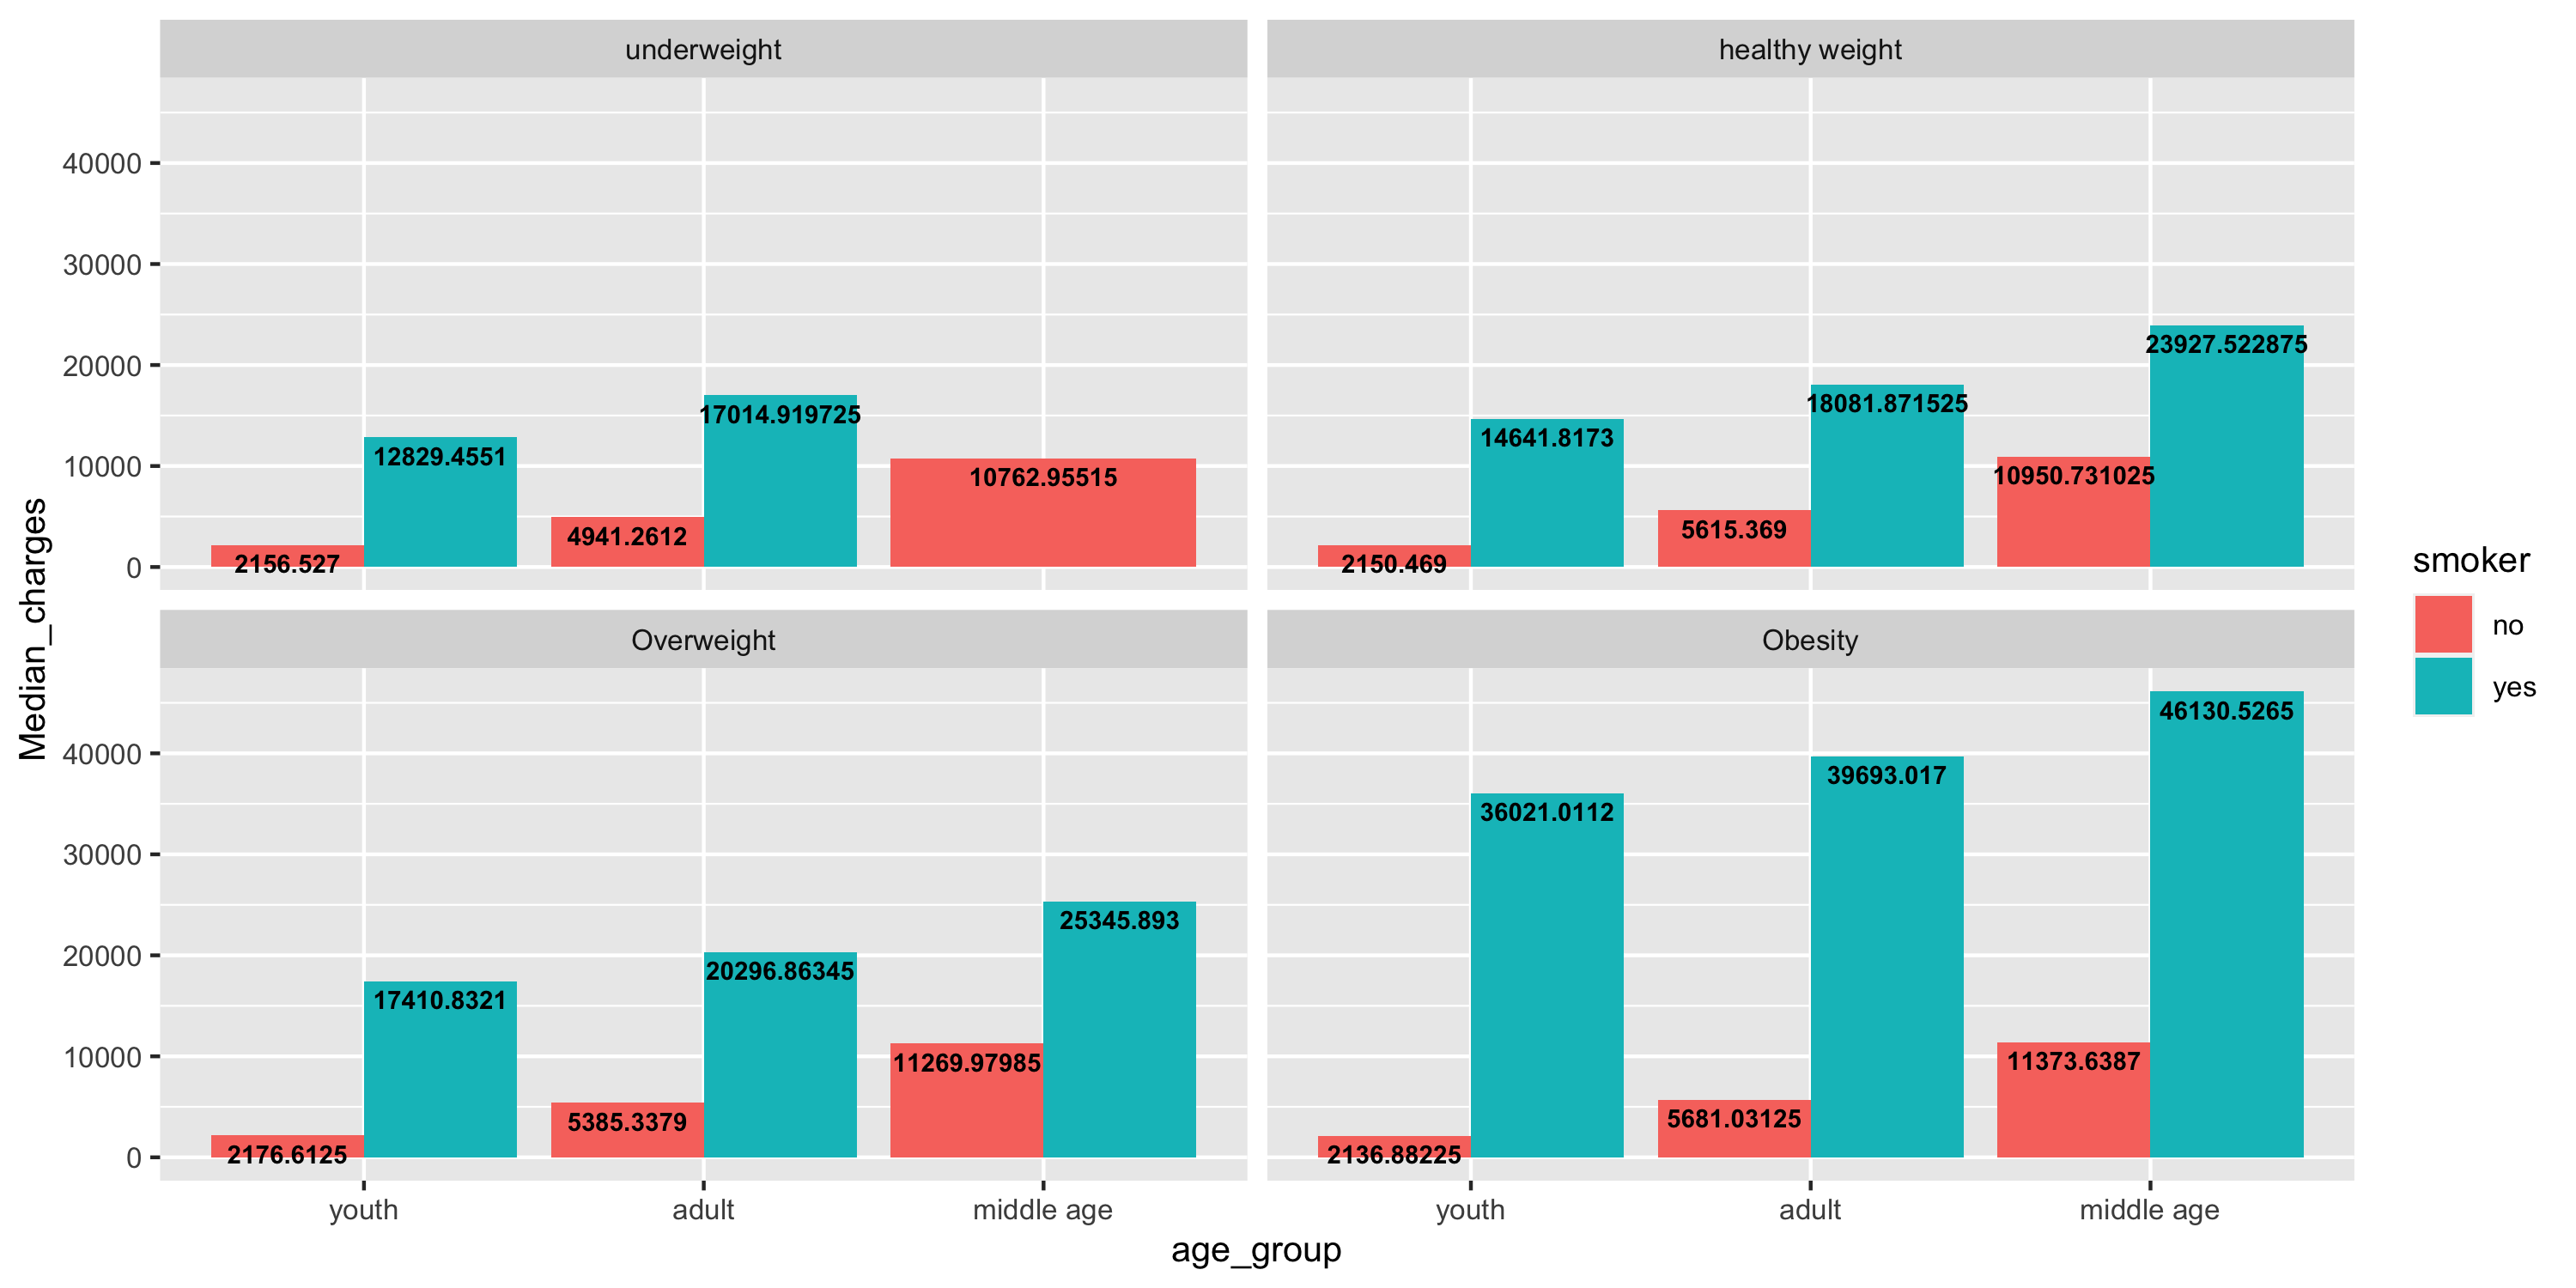

In [96]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 300)
ggplot(charges_bygroups, aes(fill=smoker, y=Median_charges, x=age_group)) + 
    geom_bar(position="dodge", stat="identity")+ facet_wrap(vars(BMI_group))+
geom_text(aes(label = Median_charges), fontface = "bold", vjust = 1.5,
             position = position_dodge(.9), size = 2.5)+
            theme(text = element_text(size = 10))

We can conclude that insurance company must target people in age group, middle age people, because they are more interested in getting insured.

## Summarize Findings

* The data seems to be already cleaned before with no missing values
* Unbalanced data set as far as smoking to non smoking is concerned
* There seems to be some specific outliers in the charges column of the dataset
* There don't seems to be any strong relationship between various columns of the dataset
* Southeast region has highest smoking to non smoking ratio
* Middle age population is more related to the higher medical costs/charges